
### Planetscope Analysis - Thresholding
***
Thresholding is a simple way of segmenting objects from a background.  
This script applies thresholding algorithms from scikit-image on vegetation indicies(NDVI, EVI, IPVI) over a study area in the Brazilian Amazon for segmenting forest/non-forest areas.



In [1]:
import matplotlib.pyplot as plt
from skimage import io, color
from skimage import data
from skimage.filters import try_all_threshold
import rasterio
from rasterio.plot import show
%matplotlib inline

In [2]:
# Images for testing
ndvi_small = "Testing_data/True_data/20190721_133242_1034_3B_AnalyticMS_Ref_clip_ndvi.tif"
evi_small = "Testing_data/True_data/20190721_133242_1034_3B_AnalyticMS_Ref_clip_evi.tif"
ipvi_small = "Testing_data/True_data/20190726_133225_103a_3B_AnalyticMS_Ref_clip_ipvi.tif"
savi_small = "Testing_data/True_data/20190726_133225_103a_3B_AnalyticMS_Ref_clip_savi.tif"

ndvi_large = "Testing_data/True_data/20190721_Ref_Mosaic_Clip_ndvi.tif"
evi_large = "Testing_data/True_data/20190721_Ref_Mosaic_Clip_evi.tif"
ipvi_large = "Testing_data/True_data/20190721_Ref_Mosaic_Clip_ipvi.tif"

Text(0.5, 1.0, 'IPVI')

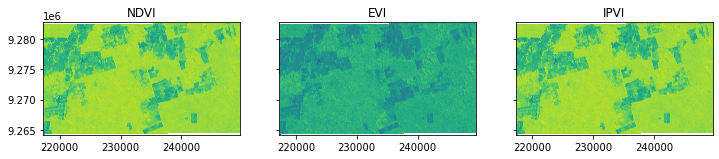

In [3]:
# Initialize subplots 
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(12, 9), sharey=True)

# Plot Red, Green and Blue (rgb)
show(rasterio.open(ndvi_large), cmap='viridis', ax=ax1)
show(rasterio.open(evi_large), cmap='viridis', ax=ax2)
show(rasterio.open(ipvi_large), cmap='viridis', ax=ax3)
# Add titles
ax1.set_title("NDVI")
ax2.set_title("EVI")
ax3.set_title("IPVI")

IPVI looks best for distinguishing forest from non-forest.   
EVI has a smoother histogram and works better for many threshold algorithms

In [4]:
with rasterio.open(ndvi_large) as src:
    ndvi_band = src.read(1)
print(ndvi_band)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


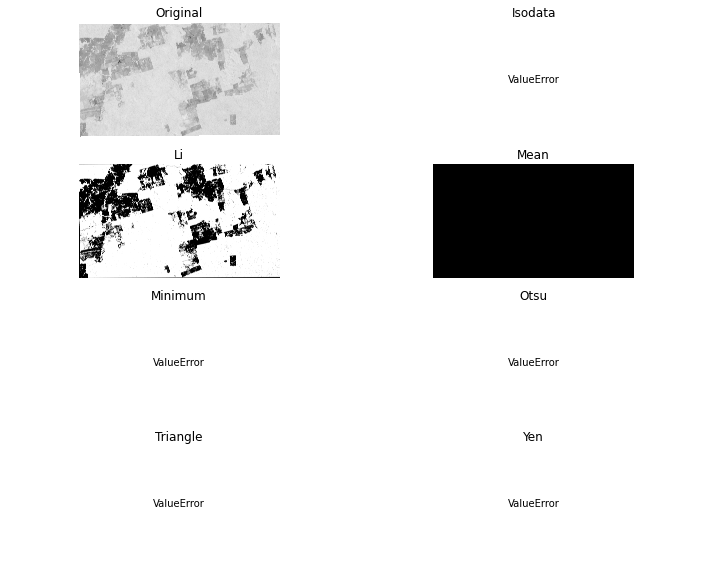

In [5]:
## This one works for EVI, but not for NDVI and IPVI
image = io.imread(ndvi_large, as_gray=True)
#img = ndvi_small

fig, ax = try_all_threshold(image, figsize=(10, 8), verbose=False)
plt.show()

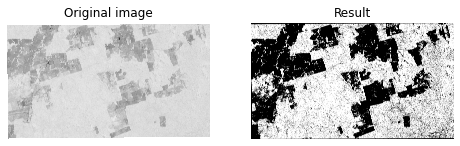

In [6]:
# Mean threshold did not work well on NDVI and IPVI because of strongly skewed distributions
# Setting mean manually

from skimage.filters import threshold_mean

thresh = 0.66
binary = image > thresh

fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(binary, cmap=plt.cm.gray)
ax[1].set_title('Result')

for a in ax:
    a.axis('off')

plt.show()

Bimodal histogram
=================

For pictures with a bimodal histogram, more specific algorithms can be used.
For instance, the minimum algorithm takes a histogram of the image and smooths it
repeatedly until there are only two peaks in the histogram.



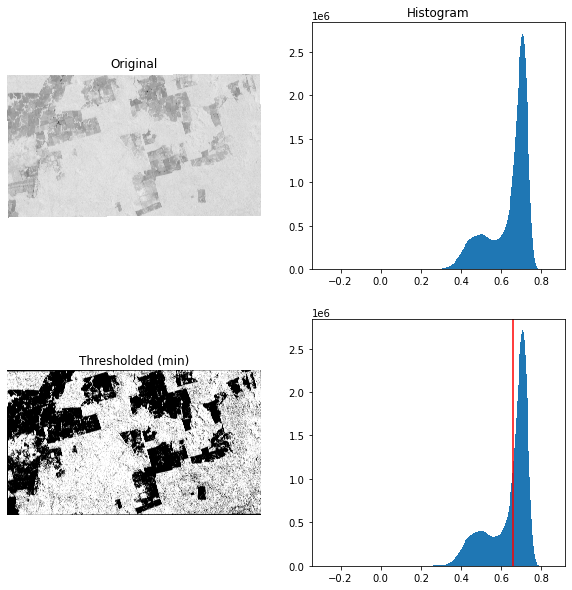

In [7]:
from skimage.filters import threshold_minimum

thresh_min = 0.66
binary_min = image > thresh_min

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(image, cmap=plt.cm.gray)
ax[0, 0].set_title('Original')

ax[0, 1].hist(image.ravel(), bins=256)
ax[0, 1].set_title('Histogram')

ax[1, 0].imshow(binary_min, cmap=plt.cm.gray)
ax[1, 0].set_title('Thresholded (min)')

ax[1, 1].hist(image.ravel(), bins=256)
ax[1, 1].axvline(thresh_min, color='r')

for a in ax[:, 0]:
    a.axis('off')
plt.show()

Otsu's method [2]_ calculates an "optimal" threshold (marked by a red line in the
histogram below) by maximizing the variance between two classes of pixels,
which are separated by the threshold. Equivalently, this threshold minimizes
the intra-class variance.

.. [2] https://en.wikipedia.org/wiki/Otsu's_method




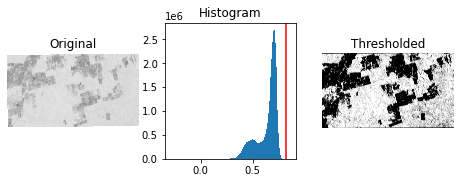

In [9]:
from skimage.filters import threshold_otsu

thresh = 0.82
binary_otsu = image > thresh

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

In [10]:
import matplotlib.pyplot as plt
from skimage import data
from skimage.morphology import disk
from skimage.filters import rank
from skimage.util import img_as_ubyte

<class 'numpy.ndarray'>


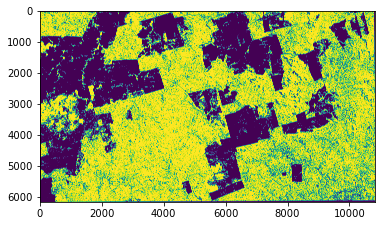

In [11]:
# Test 
img_ubyte = img_as_ubyte(binary)
print(type(binary))
plt.imshow(binary)


Applying majority filter to smoothen results

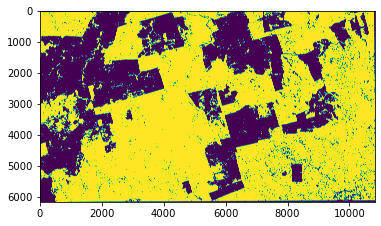

In [19]:
from skimage import data
from skimage.filters.rank import majority
from skimage.morphology import disk, ball
import numpy as np

#volume = np.random.randint(0, 255, size=(1,1,1), dtype=np.uint8)
maj_img = majority(img_ubyte, disk(10))
plt.imshow(maj_img)

In [20]:
print(src.meta)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': 0.0, 'width': 10809, 'height': 6167, 'count': 1, 'crs': CRS.from_epsg(32722), 'transform': Affine(3.0, 0.0, 217230.0,
       0.0, -3.0, 9282714.0)}


In [21]:
# Export segmented mask
from rasterio import uint8
# Set spatial characteristics of the output object to mirror the input
kwargs = src.meta
kwargs.update(
    dtype=rasterio.uint8,
    nodata=0.2,
    count = 1)

# Create the file
with rasterio.open(ndvi_large.replace('.tif', '_Mask.tif'), 'w', **kwargs) as dst:
                   dst.write_band(1, maj_img)
print("done")

done


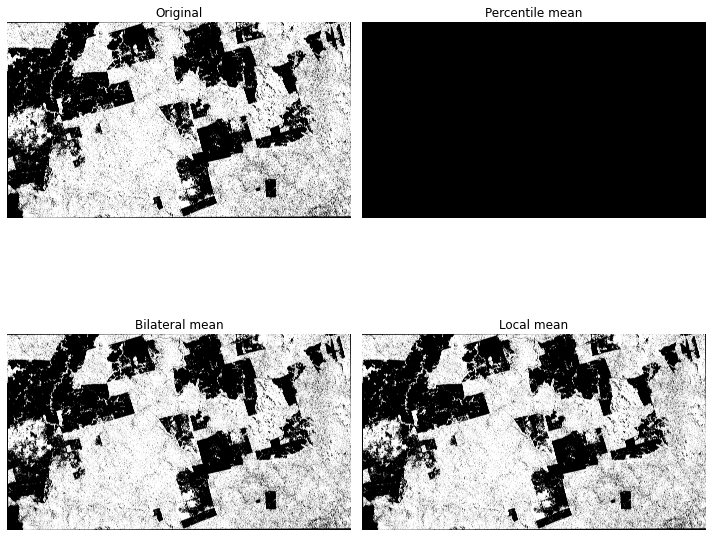

In [15]:
# Testing mean filter
from skimage import data
from skimage.morphology import disk
from skimage.filters import rank

image = img_ubyte
selem = disk(5)

percentile_result = rank.mean_percentile(image, selem=selem, p0=.1, p1=.9)
bilateral_result = rank.mean_bilateral(image, selem=selem, s0=500, s1=500)
normal_result = rank.mean(image, selem=selem)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10),
                         sharex=True, sharey=True)
ax = axes.ravel()
titles = ['Original', 'Percentile mean', 'Bilateral mean', 'Local mean']
imgs = [image, percentile_result, bilateral_result, normal_result]
for n in range(0, len(imgs)):
    ax[n].imshow(imgs[n], cmap=plt.cm.gray)
    ax[n].set_title(titles[n])
    ax[n].axis('off')

plt.tight_layout()
plt.show()